# Libraries 

In [6]:
## Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import sys
from pathlib import Path

# path to the directory that CONTAINS the package folder
project_root = Path("/home/benedetti/PL")   # adjust to your real path

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## PyTorch
import torch
from torch.utils.data import DataLoader

from PL.utils.saving import load_training

from PL.training.training_classifier import train_model, initialize

device = torch.device("cuda:1")

data_PATH = "/home/benedetti/VecPerc/data/"


# Dataset and model

In [ ]:
# Nature of variables and loss
d=4
spin_type = "vector"
loss_type = "CE"
init_Hebb = True
fixed_norm = False
l2 = None

# Dataset
alpha_P = 1.
N=250
sigma = 1.
P = int(alpha_P * N)
print("N={}, P={}".format(N,P))

# Model and training
l=1.    
downf=0.01
gamma=0.0
lr = 0.001

epochs=100
valid_every = 10
max_grad = 20.
batch_size = P

N=250, P=250


In [3]:
dataset, model, optimizer = initialize(N, P, d, lr, spin_type,device, gamma, init_Hebb=init_Hebb, downf=downf)
J2 = model.J.data.clone().cpu()
norm_J2 = torch.norm(J2)

In [ ]:
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,          # important for fast H2D
    persistent_workers=True,  # avoids worker respawn overhead
    prefetch_factor=2,        # default is 2 when num_workers>0
)

#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=2)

epochs_to_save = [10,20,40,200]
save = True
print("epochs:{}  lr:{}  max_norm:{}  l:{}".format(epochs, lr, max_grad, l))


epochs:1000  lr:0.01  max_norm:20.0  l:1.0


# Training

## One training

In [6]:
model_name_base = "{}_{}_GD_TEACHER_fixed{}_N_{}_P_{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, fixed_norm, N, P, l, epochs, lr, l2)
model_name = model_name_base + ".pth"
print(model_name)

vector_CE_GD_TEACHER_fixedFalse_N_250_P_250_l_1.0_epochs1000_lr0.01_l2None.pth


In [7]:
train_model(
    model, fixed_norm, dataset, dataloader, epochs, 
    lr, max_grad, device, data_PATH, l, optimizer, J2, 
    norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, loss_type
)

# epoch norm train_loss learning_rate train_metric R


20 0.3718712627887726 2.3172829151153564 0.01 0.9585466980934143 0.4322293996810913
40 0.6058017015457153 1.9084330797195435 0.01 0.9692817330360413 0.43833285570144653
60 0.7946677803993225 1.6331883668899536 0.01 0.9757778644561768 0.4421040117740631
80 0.9570391178131104 1.427817940711975 0.01 0.980095386505127 0.4446665048599243
100 1.101583480834961 1.2646045684814453 0.01 0.9831610918045044 0.4465242922306061
120 1.233109951019287 1.1294084787368774 0.01 0.9854447841644287 0.4479347765445709
140 1.354600429534912 1.0141229629516602 0.01 0.9872085452079773 0.4490426480770111
160 1.468050479888916 0.9136911630630493 0.01 0.9886098504066467 0.44993630051612854
180 1.5748720169067383 0.8247545957565308 0.01 0.9897487163543701 0.4506722688674927
200 1.6761069297790527 0.7449724674224854 0.01 0.9906914830207825 0.45128902792930603
220 1.7725497484207153 0.6726498007774353 0.01 0.9914840459823608 0.45181310176849365
240 1.8648229837417603 0.6065205335617065 0.01 0.9921592473983765 0.452

## Many trainings

In [14]:
# Nature of variables and loss
spin_type = "vector"
loss_type = "CE"
init_Hebb = True
fixed_norm = True
l2 = None

# Dataset
alpha_P = 1.
N=250
sigma = 1.
P = int(alpha_P * N)
print("N={}, P={}".format(N,P))

# Model and training   
downf=1.
gamma=0.0
lr = 1.
epochs=100
valid_every = 50
max_grad = 20.
batch_size = P

N=250, P=250


In [15]:
l_arr = np.array([0.1,0.2,0.4,0.8,1.6,3.2,6.4])
#l_arr = np.array([1.])
d_arr = np.array([4,8,16,32])
alpha_P_arr = np.array([0.5, 1., 2., 4., 8., 16.])
seeds_arr = np.arange(100,105)

In [16]:
curve = np.zeros((len(seeds_arr), len(d_arr), len(alpha_P_arr), len(l_arr)))

for i_s, seed in tqdm(enumerate(seeds_arr)):
    for i_d, d in enumerate(d_arr):
        for i_a, alpha_P in enumerate(alpha_P_arr):
            P = int(alpha_P*N)
            dataset, model, optimizer = initialize(N, P, d, lr, spin_type,device, gamma, init_Hebb=init_Hebb, downf=downf, seed=seed)
            J2 = model.J.clone().squeeze().cpu().detach().numpy()
            norm_J2 = np.linalg.norm(J2)

            batch_size = P
            dataloader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=2,
                pin_memory=True,          # important for fast H2D
                persistent_workers=True,  # avoids worker respawn overhead
                prefetch_factor=2,        # default is 2 when num_workers>0
            )

            #epochs_to_save = [10,20,50,100,200,400,800,1600]
            #save = True
            epochs_to_save = [1000]
            save = False

            for i_l, l in enumerate(l_arr):
                print("########")
                print("d:{} alpha_P:{} lambda:{} seed:{} epochs:{}  lr:{}  max_norm:{}  ".format(d, alpha_P, l, seed, epochs, lr, max_grad))
                model_name_base = "{}_{}_GD_TEACHER_fixed{}_N_{}_P_{}_d{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, fixed_norm, N, P, d, l, epochs, lr, l2)
                model_name = model_name_base + ".pth"
                print(model_name)
                train_model(
                    model, fixed_norm, dataset, dataloader, epochs, 
                    lr, max_grad, device, data_PATH, l, optimizer, J2, 
                    norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, loss_type
                )

                R = (torch.einsum("iab,iab->", dataset.T.to(device), model.J) / (dataset.T.to(device).norm() * model.J.norm())).cpu().item()

                curve[i_s, i_d, i_a, i_l] = R  
                
                

0it [00:00, ?it/s]

########
d:4 alpha_P:0.5 lambda:0.1 seed:100 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.1_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 24.84552764892578 1.0 0.9795817732810974 0.32115504145622253
########
d:4 alpha_P:0.5 lambda:0.2 seed:100 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.2_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 9.91299057006836 1.0 0.9881325960159302 0.32459861040115356
########
d:4 alpha_P:0.5 lambda:0.4 seed:100 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.4_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 3.1222832202911377 1.0 0.994861900806427 0.32731521129608154
########
d:4 alpha_P:0.5 lambda:0.8 seed:100 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.8_epochs100_lr1.0_l2None.pt

1it [15:16, 916.50s/it]

########
d:4 alpha_P:0.5 lambda:0.1 seed:101 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.1_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 24.873151779174805 1.0 0.9782216548919678 0.3321034610271454
########
d:4 alpha_P:0.5 lambda:0.2 seed:101 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.2_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 9.938603401184082 1.0 0.9873107671737671 0.3358974754810333
########
d:4 alpha_P:0.5 lambda:0.4 seed:101 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.4_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 3.141707420349121 1.0 0.9945112466812134 0.3389332592487335
########
d:4 alpha_P:0.5 lambda:0.8 seed:101 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.8_epochs100_lr1.0_l2None.pth

2it [30:28, 913.59s/it]

########
d:4 alpha_P:0.5 lambda:0.1 seed:102 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.1_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 24.808406829833984 1.0 0.9789853692054749 0.32112276554107666
########
d:4 alpha_P:0.5 lambda:0.2 seed:102 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.2_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 1.9999998807907104 9.883188247680664 1.0 0.9878792762756348 0.32479023933410645
########
d:4 alpha_P:0.5 lambda:0.4 seed:102 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.4_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.000000238418579 3.10323429107666 1.0 0.9948078393936157 0.32766464352607727
########
d:4 alpha_P:0.5 lambda:0.8 seed:102 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l

3it [45:41, 913.45s/it]

########
d:4 alpha_P:0.5 lambda:0.1 seed:103 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.1_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 24.827884674072266 1.0 0.9819044470787048 0.2971366345882416
########
d:4 alpha_P:0.5 lambda:0.2 seed:103 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.2_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 1.9999998807907104 9.892302513122559 1.0 0.9893748760223389 0.3000600337982178
########
d:4 alpha_P:0.5 lambda:0.4 seed:103 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.4_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 3.104351282119751 1.0 0.9953632354736328 0.3024190366268158
########
d:4 alpha_P:0.5 lambda:0.8 seed:103 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.8_epochs100_l

4it [1:00:54, 913.42s/it]

########
d:4 alpha_P:0.5 lambda:0.1 seed:104 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.1_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 24.86055564880371 1.0 0.9783510565757751 0.3186090588569641
########
d:4 alpha_P:0.5 lambda:0.2 seed:104 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.2_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 9.926170349121094 1.0 0.987235426902771 0.3224584758281708
########
d:4 alpha_P:0.5 lambda:0.4 seed:104 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.4_epochs100_lr1.0_l2None.pth
# epoch norm train_loss learning_rate train_metric R
50 2.0 3.1329352855682373 1.0 0.9943897724151611 0.3255586326122284
########
d:4 alpha_P:0.5 lambda:0.8 seed:104 epochs:100  lr:1.0  max_norm:20.0  
vector_CE_GD_TEACHER_fixedTrue_N_250_P_125_d4_l_0.8_epochs100_lr1.0_l2None.pth


5it [1:16:02, 912.42s/it]


In [ ]:
name = "numerical_result_PL_2"

np.save(data_PATH+name, curve)

# Analysis

## Fixed norm

In [ ]:
# Nature of variables and loss
spin_type = "vector"
loss_type = "CE"
init_Hebb = True
fixed_norm = True
l2 = None

# Dataset
alpha_P = 1.
N=250
sigma = 1.

# Model and training   
downf=1.
gamma=0.0
lr = 1.
epochs=60
valid_every = 30
max_grad = 20.

METRIC_NAMES = [
    "epoch",
    "norm_J",
    "train_loss",
    "train_accuracy",
    "R",
    "learning_rate",
    "diff_hebb",
]

In [6]:
def angular_loss(d: int, R: float, n_samples: int = 200_000, seed: int | None = 0) -> float:
    if d < 1:
        raise ValueError("d must be >= 1")
    if not (-1.0 <= R <= 1.0):
        raise ValueError("R must be in [-1, 1]")

    rng = np.random.default_rng(seed)
    u = rng.standard_normal((n_samples, d))
    w = rng.standard_normal((n_samples, d))
    v = R * u + np.sqrt(max(0.0, 1.0 - R**2)) * w

    dot = np.sum(u * v, axis=1)
    nu = np.linalg.norm(u, axis=1)
    nv = np.linalg.norm(v, axis=1)

    cosang = dot / (nu * nv)
    cosang = np.clip(cosang, -1.0, 1.0)

    return float(np.mean(np.arccos(cosang)))*2/np.pi

In [7]:
print(angular_loss(d=16, R=0.1))

0.9367453636568502


In [ ]:
l_arr = np.array([0.1,0.2,0.4,0.8,1.6,3.2,6.4])
#l_arr = np.array([1.])
d_arr = np.array([4,8,16,32])
alpha_P_arr = np.array([0.5, 1., 2., 4., 8., 16.])


curve = np.zeros((len(seeds_arr), len(d_arr), len(alpha_P_arr), len(l_arr)))

for i_d, d in enumerate(d_arr):
    for i_a, alpha_P in enumerate(alpha_P_arr):
        for i_l, l in enumerate(l_arr):
            P = int(alpha_P*N)
            print("########")
            print("d:{} alpha_P:{} lambda:{} epochs:{}  lr:{}  max_norm:{}  ".format(d, alpha_P, l, epochs, lr, max_grad))
            model_name_base = "{}_{}_GD_TEACHER_fixed{}_N_{}_P_{}_d{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, fixed_norm, N, P, d, l, epochs, lr, l2)
            model_name = model_name_base + ".pth"
            save_idx = -1
            h5_path = os.path.join(data_PATH, model_name_base + ".h5")
            # 4. Load weights + metrics
            dataset, model, optimizer = initialize(N, P, d, lr, spin_type,device, gamma, init_Hebb=init_Hebb, downf=downf)
            model, optimizer, metrics, epoch_saved = load_training(
                h5_path=h5_path,
                save_idx=save_idx,
                model=model,
                METRIC_NAMES=METRIC_NAMES,
                device=device,
            )
            print("d:{} alpha:{} l:{} ".format(d, alpha_P, l))
            epsilon = angular_loss(d, metrics["R"][-1])
            curve[i_d, i_a, i_l] = metrics["R"][-1] 
            print(metrics["R"], epsilon)

########
d:4 alpha_P:0.5 lambda:0.1 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:0.1 
[0.33171055 0.33171052] 0.7836881080483818
########
d:4 alpha_P:0.5 lambda:0.2 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:0.2 
[0.33539799 0.33539799] 0.7811948141125121
########
d:4 alpha_P:0.5 lambda:0.4 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:0.4 
[0.33834127 0.33834124] 0.7792024224488748
########
d:4 alpha_P:0.5 lambda:0.8 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:0.8 
[0.33986554 0.33986554] 0.778169752940551
########
d:4 alpha_P:0.5 lambda:1.6 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:1.6 
[0.34044579 0.34044528] 0.7777768451214486
########
d:4 alpha_P:0.5 lambda:3.2 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:3.2 
[0.33734196 0.33210805] 0.7834194679327856
########
d:4 alpha_P:0.5 lambda:6.4 epochs:60  lr:1.0  max_norm:20.0  
d:4 alpha:0.5 l:6.4 
[0.32360509 0.32335857] 0.7893236888953217
########
d:4 alpha_P:1.0 lambda:0.1 epochs:60  lr:1.0  m

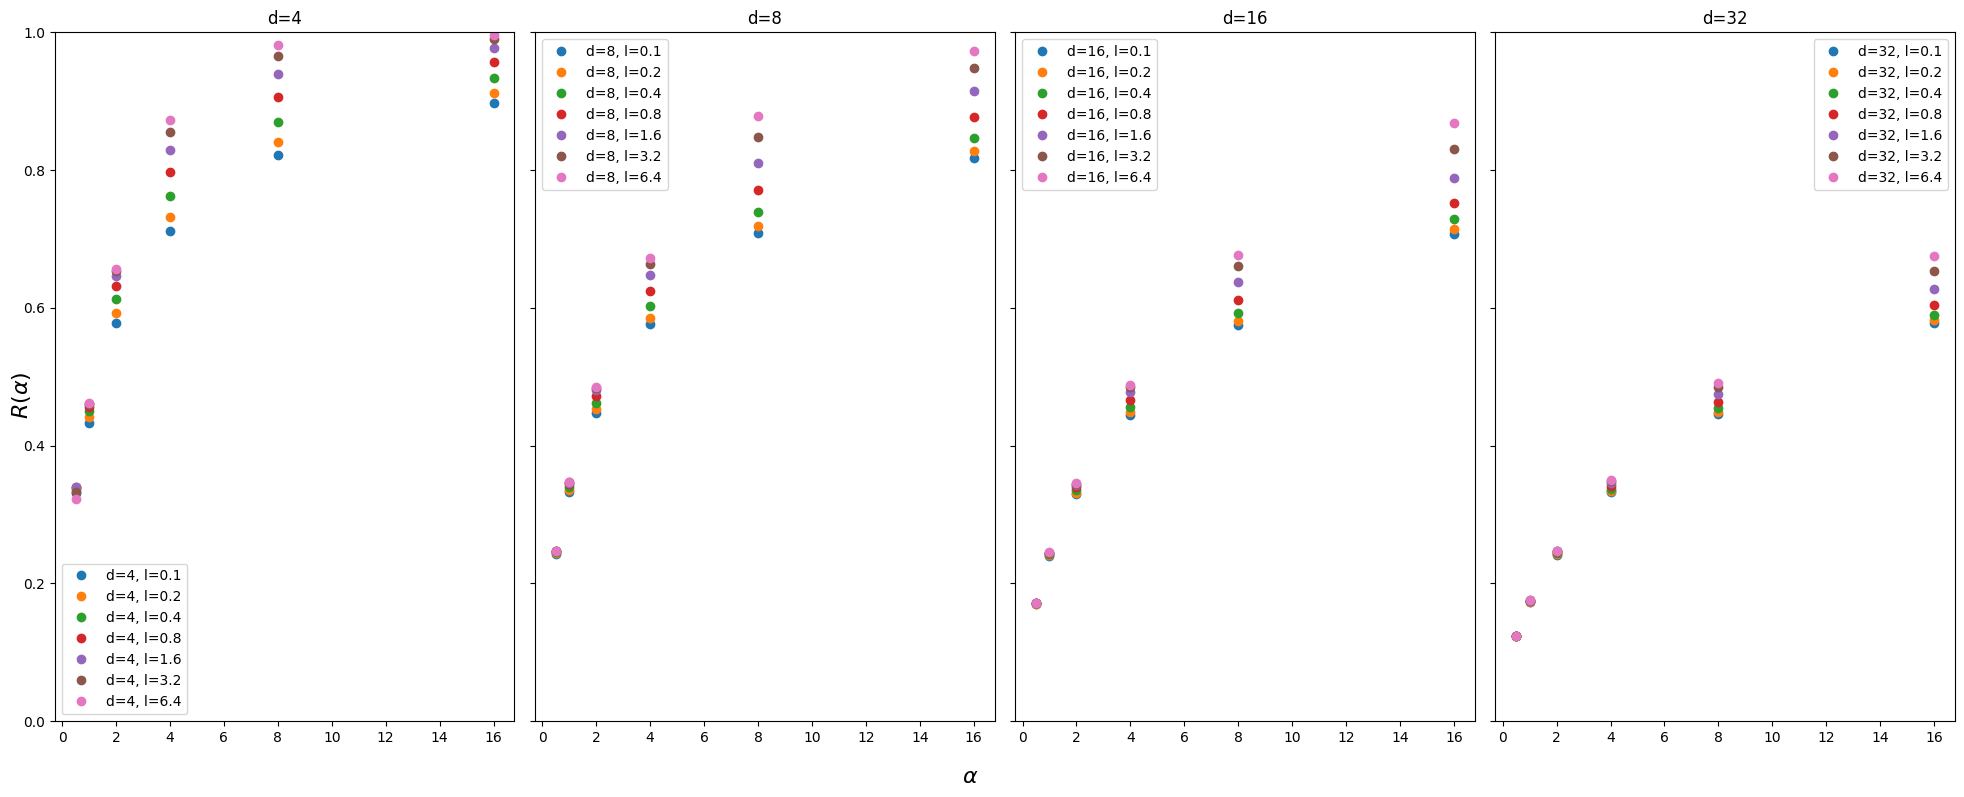

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8), sharex=True, sharey=True)

for i_d, ax in enumerate(axs):
    d = d_arr[i_d]
    ax.set_title(f"d={d}")
    for i_l, l in enumerate(l_arr):
        ax.plot(alpha_P_arr, curve[i_d, :, i_l], "o", label="d={}, l={}".format(d, l))
    ax.set_ylim((0, 1.0))
    ax.legend()

# common labels
fig.supxlabel(r"$\alpha$", fontsize=16)
fig.supylabel(r"$R(\alpha)$", fontsize=16)

plt.tight_layout()
plt.show()



In [10]:
name = "numerical_result_N500"

np.save("/home/benedetti/PL_library_study/analysis/"+name, curve)

## Free norm

In [5]:
# Nature of variables and loss
spin_type = "vector"
loss_type = "CE"
init_Hebb = True
fixed_norm = False
l2 = None

# Dataset
alpha_P = 1.
N=250
sigma = 1.
P = int(alpha_P * N)
print("N={}, P={}".format(N,P))

# Model and training   
downf=0.01
gamma=0.0
lr = 0.05
epochs=2000
valid_every = 10
max_grad = 20.
batch_size = P

METRIC_NAMES = [
    "epoch",
    "norm_J",
    "train_loss",
    "train_accuracy",
    "R",
    "learning_rate",
    "diff_hebb",
]

N=250, P=250


In [6]:
l_arr = np.array([1.])
d_arr = np.array([4,8,16,32])
alpha_P_arr = np.array([0.5, 1., 2., 4., 8., 16.])

In [10]:
#epochs_to_save = [10,20,50,100,200,400,800,1600]

t_arr = np.arange(5,2001,5)

curve = np.zeros((len(d_arr), len(alpha_P_arr), len(t_arr)))
l_numerical = np.zeros((len(d_arr), len(alpha_P_arr), len(t_arr)))

for i_d, d in enumerate(d_arr):
    for i_a, alpha_P in enumerate(alpha_P_arr):  
        P = int(alpha_P*N)
        print("########")
        print("d:{} alpha_P:{} lambda:{} epochs:{}  lr:{}  max_norm:{}  ".format(d, alpha_P, l, epochs, lr, max_grad))
        model_name_base = "{}_{}_GD_TEACHER_fixed{}_N_{}_P_{}_d{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, fixed_norm, N, P, d, l, epochs, lr, l2)
        model_name = model_name_base + ".pth"
        save_idx = -1
        h5_path = os.path.join(data_PATH, model_name_base + ".h5")
        # 4. Load weights + metrics
        dataset, model, optimizer = initialize(N, P, d, lr, spin_type,device, gamma, init_Hebb=init_Hebb, downf=downf)
        model, optimizer, metrics, epoch_saved = load_training(
            h5_path=h5_path,
            save_idx=save_idx,
            model=model,
            METRIC_NAMES=METRIC_NAMES,
            device=device,
        )
        print("d:{} alpha:{}".format(d, alpha_P))
        curve[i_d, i_a] = metrics["R"] 
        l_numerical[i_d, i_a] = metrics["norm_J"]
        print(metrics["R"])

########
d:4 alpha_P:0.5 lambda:1.0 epochs:2000  lr:0.05  max_norm:20.0  
d:4 alpha:0.5
[0.31787392 0.32022333 0.32131776 0.32194576 0.32235119 0.32263365
 0.32284135 0.32300031 0.32312578 0.32322732 0.32331109 0.32338148
 0.32344142 0.32349306 0.32353806 0.32357758 0.32361263 0.32364395
 0.32367203 0.32369742 0.32372048 0.32374156 0.32376084 0.32377854
 0.32379493 0.32381013 0.3238242  0.32383737 0.32384965 0.32386112
 0.32387194 0.3238821  0.32389167 0.32390073 0.32390928 0.32391736
 0.32392505 0.32393247 0.32393941 0.323946   0.32395241 0.32395843
 0.32396424 0.32396987 0.32397515 0.32398024 0.32398516 0.32398987
 0.32399446 0.32399881 0.32400301 0.32400706 0.32401109 0.32401481
 0.32401851 0.32402208 0.32402548 0.32402882 0.32403204 0.3240352
 0.32403821 0.32404116 0.32404402 0.32404685 0.3240495  0.32405216
 0.32405472 0.32405722 0.32405961 0.32406199 0.32406428 0.32406658
 0.32406878 0.3240709  0.32407302 0.32407501 0.32407704 0.32407898
 0.32408088 0.32408276 0.32408455 0.324086

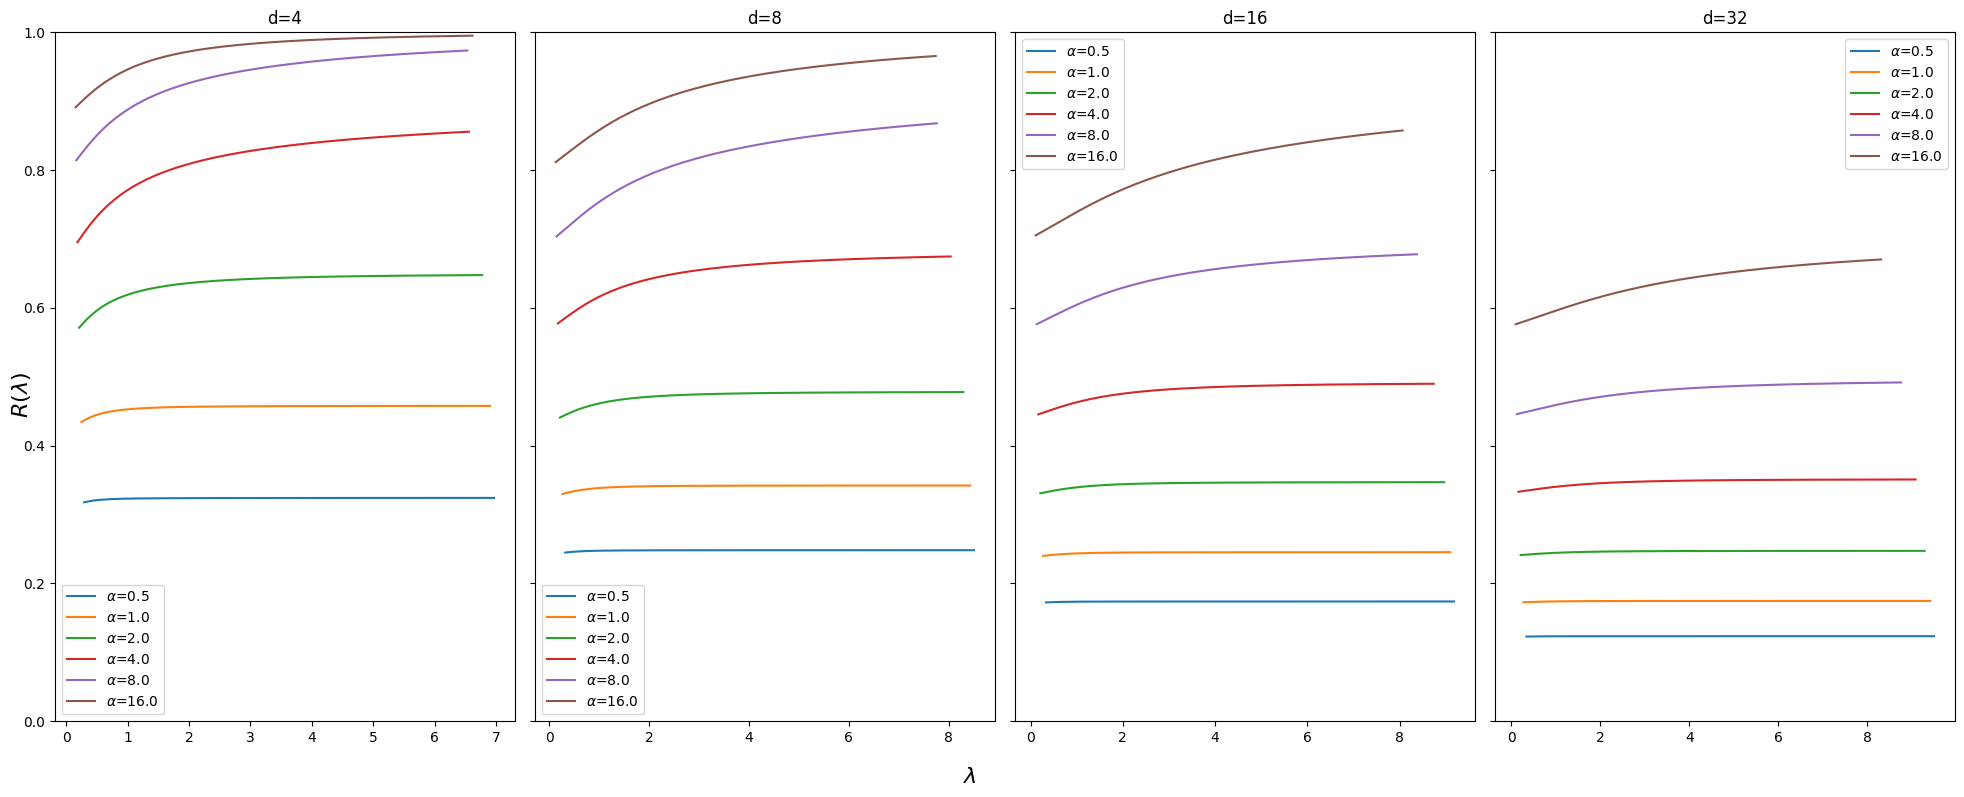

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8), sharey=True)

for i_d, ax in enumerate(axs):
    d = d_arr[i_d]
    ax.set_title(f"d={d}")
    for i_a, alpha in enumerate(alpha_P_arr):
        ax.plot(l_numerical[i_d, i_a, :-1], curve[i_d, i_a, :-1], "-", label=r"$\alpha$={}".format(alpha))
        
    ax.set_ylim((0, 1.0))
    ax.legend()

# common labels
fig.supxlabel(r"$\lambda$", fontsize=16)
fig.supylabel(r"$R(\lambda)$", fontsize=16)

plt.tight_layout()
plt.show()

In [12]:
name = "results_free_norm"

to_save = np.zeros((2,len(d_arr), len(alpha_P_arr), len(t_arr)))

to_save[0] = l_numerical
to_save[1] = curve

np.save("/home/benedetti/PL_library_study/analysis/"+name, to_save)